# Андрей_Кузнецов_123436886
# Score: 0.99574

# Классификация персонажей, проживающих в Спрингфилде

### Импорт зависимостей

In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f2ee6d33b02de82d258069717d3e4a891ee42fdc71ba3c521ac0dd1372996707
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [81]:
import torch
import numpy as np
import pickle
import skimage.io as io
import torch.nn as nn
import random
import time
import copy
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### Воспроизводимость результатов

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Проверка CUDA

In [6]:
!nvidia-smi
torch.cuda.is_available()

Mon Nov 22 09:08:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

### Подготовка набора

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $,<br>
константы – средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.<br>
Также используется LabelEncoder для преобразования строковых меток классов в id и обратно.


В описании набора указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)
 
 https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

#### Код итератора и вывода

Аугментация

https://stepik.org/lesson/345648/step/1?discussion=1678056&unit=609598

In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [61]:
DATA_MODES = ['train', 'val', 'test'] # разные режимы
RESCALE_SIZE = 224 # все изображения будут масштабированы к размеру 224x224
DEVICE = torch.device("cuda") # работаем на видеокарте

TRAIN_PATH = '/content/gdrive/MyDrive/springfield/train'
TEST_PATH = '/content/gdrive/MyDrive/springfield/test'

In [12]:
class SimpsonsDataset(Dataset):
    """
    Набор с картинками, который:
    * паралельно подгружает их из папок,
    * производит масштабирование
    * и превращение в Pytorch-тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # список файлов для загрузки
        self.mode = mode # режим работы

        if self.mode not in DATA_MODES:
            print(f"{self.mode} неправильный режим; правильные режимы работы: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    def __getitem__(self, index):
        data_transforms = {
            'train': transforms.Compose([
                # аугментации
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                # у этих картинок mean и std задаются такими значениями
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['test'])
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

#### Загрузка

In [14]:
TRAIN_DIR = Path(TRAIN_PATH)
TEST_DIR = Path(TEST_PATH)
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [15]:
train_labels = [path.parent.name for path in train_files] # ярлыки – названия папок
train_files, val_files = train_test_split(train_files, test_size=0.20, \
                                          stratify=train_labels)

n_classes = len(np.unique(train_labels))
print(n_classes)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

42


#### Undersampling

Балансировка классов путём повторения примеров классов с небольшим числом примеров

https://stepik.org/lesson/345648/step/1?discussion=1634693&unit=609598

In [16]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [17]:
# Создадим словарь в котором ключами будут персонажи Симпсонов,
# а значениями списки с путями к картинкам
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
    
new_train_files = []
for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

abraham_grampa_simpson	730
agnes_skinner	100
apu_nahasapeemapetilon	498
barney_gumble	100
bart_simpson	1074
carl_carlson	100
charles_montgomery_burns	954
chief_wiggum	789
cletus_spuckler	100
comic_book_guy	375
disco_stu	100
edna_krabappel	366
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1797
kent_brockman	398
krusty_the_clown	965
lenny_leonard	248
lionel_hutz	100
lisa_simpson	1083
maggie_simpson	102
marge_simpson	1033
martin_prince	100
mayor_quimby	197
milhouse_van_houten	863
miss_hoover	100
moe_szyslak	1161
ned_flanders	1163
nelson_muntz	286
otto_mann	100
patty_bouvier	100
principal_skinner	955
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	702
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	145


In [18]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

#### Проверка

Посмотри на персонажей внутри набора.

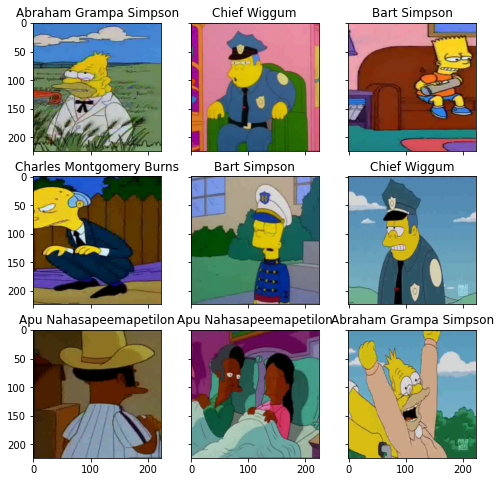

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Код обучения и предсказания

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html </br>
https://stepik.org/lesson/345648/step/1?discussion=1634696&unit=609598

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def train(train_dataset, val_dataset,
          model, criterion,
          epochs, batch_size,
          optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    start_time = time.time();
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    best_weights = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1): # нумерация с единицы
            print(f"epoch {epoch}:\n")
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if val_loss < best_loss:
                best_acc = val_loss
                best_epoch = epoch
                best_weights = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
         
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))

    model.load_state_dict(best_weights)
            
    return history

In [63]:
def predict(model, test_loader, device=DEVICE):
    with torch.no_grad():
        logits = []     
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Fine Tuning EfficientNet

https://stepik.org/lesson/345648/step/1?discussion=1634513&unit=609598
https://youtu.be/XSPYe4-y4HE

In [25]:
model = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [26]:
# Заморозка обучения:
for param in model.parameters():
    param.requires_grad = False
    
model_n_features = model._fc.in_features
model._fc = nn.Linear(model_n_features, n_classes) # этот слой будет учиться

model = model.to(DEVICE)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

### Обучение последнего слоя

In [28]:
feat_extraction_n_epochs = 5

In [29]:
feat_extraction_history = train(train_dataset, val_dataset,
                                model=model, criterion=criterion,
                                epochs=feat_extraction_n_epochs, batch_size=128,
                                optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1:

train loss: 2.553751257409241


epoch:  20%|██        | 1/5 [04:20<17:22, 260.53s/it]

val loss: 1.9871196195052578

Epoch 002 train_loss: 2.5538     val_loss 1.9871 train_acc 0.4020 val_acc 0.5672

epoch 2:

train loss: 1.656385789112713


epoch:  40%|████      | 2/5 [08:39<12:59, 259.80s/it]

val loss: 1.4442514060134104

Epoch 003 train_loss: 1.6564     val_loss 1.4443 train_acc 0.6294 val_acc 0.6716

epoch 3:

train loss: 1.324801983355516


epoch:  60%|██████    | 3/5 [13:00<08:40, 260.41s/it]

val loss: 1.2401675376227002

Epoch 004 train_loss: 1.3248     val_loss 1.2402 train_acc 0.6768 val_acc 0.7060

epoch 4:

train loss: 1.1892061933685112


epoch:  80%|████████  | 4/5 [17:22<04:20, 260.84s/it]

val loss: 1.1727774536692217

Epoch 005 train_loss: 1.1892     val_loss 1.1728 train_acc 0.7039 val_acc 0.7175

epoch 5:

train loss: 1.1292456859071578


epoch: 100%|██████████| 5/5 [21:42<00:00, 260.49s/it]

val loss: 1.1216372164673187

Epoch 006 train_loss: 1.1292     val_loss 1.1216 train_acc 0.7177 val_acc 0.7263

Training complete in 21m 43s
Best val loss: 10.000000
Best epoch: 5


In [31]:
loss, acc, val_loss, val_acc = zip(*feat_extraction_history)

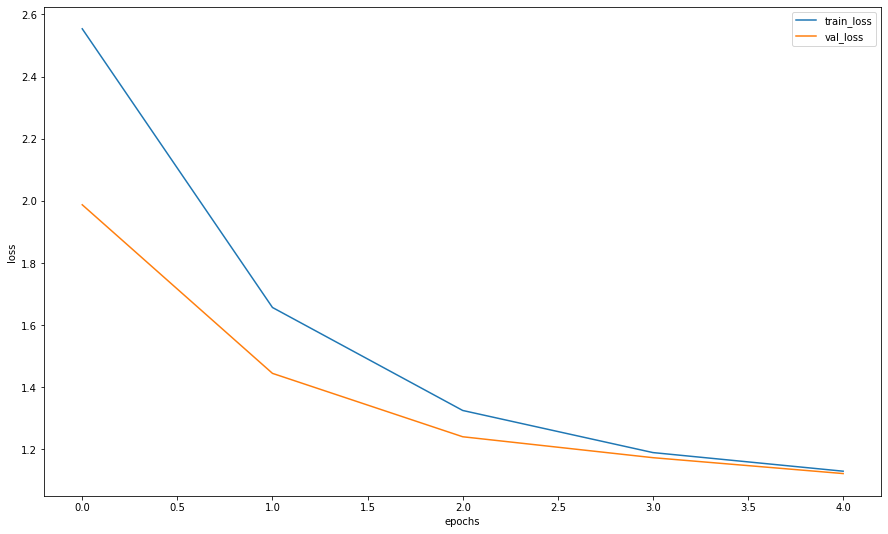

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Обучение всех слоёв

In [36]:
for param in model.parameters():
    param.requires_grad = True

In [39]:
fine_tuning_epochs = 20

In [41]:
torch.cuda.empty_cache()

In [43]:
fine_tune_history = train(train_dataset=train_dataset, val_dataset=val_dataset,
                          model=model, criterion=criterion,
                          epochs=finetuning_epochs, batch_size=64,
                          optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

epoch 1:

train loss: 0.35410595141156254


epoch:   7%|▋         | 1/15 [07:33<1:45:53, 453.79s/it]

val loss: 0.19659321057802173

Epoch 002 train_loss: 0.3541     val_loss 0.1966 train_acc 0.9078 val_acc 0.9489

epoch 2:

train loss: 0.08631244103949799


epoch:  13%|█▎        | 2/15 [15:07<1:38:19, 453.83s/it]

val loss: 0.10910404286789302

Epoch 003 train_loss: 0.0863     val_loss 0.1091 train_acc 0.9779 val_acc 0.9744

epoch 3:

train loss: 0.049071248273924076


epoch:  20%|██        | 3/15 [22:40<1:30:39, 453.33s/it]

val loss: 0.11869964506170161

Epoch 004 train_loss: 0.0491     val_loss 0.1187 train_acc 0.9871 val_acc 0.9694

epoch 4:

train loss: 0.0352494358056975


epoch:  27%|██▋       | 4/15 [30:13<1:23:06, 453.32s/it]

val loss: 0.14658230541918782

Epoch 005 train_loss: 0.0352     val_loss 0.1466 train_acc 0.9901 val_acc 0.9701

epoch 5:

train loss: 0.01671134188074839


epoch:  33%|███▎      | 5/15 [37:47<1:15:34, 453.41s/it]

val loss: 0.11497329043961454

Epoch 006 train_loss: 0.0167     val_loss 0.1150 train_acc 0.9950 val_acc 0.9764

epoch 6:

train loss: 0.010120428058796744


epoch:  40%|████      | 6/15 [45:20<1:08:01, 453.50s/it]

val loss: 0.13738371328568497

Epoch 007 train_loss: 0.0101     val_loss 0.1374 train_acc 0.9968 val_acc 0.9747

epoch 7:

train loss: 0.008485506339142612


epoch:  47%|████▋     | 7/15 [52:54<1:00:27, 453.49s/it]

val loss: 0.12923555656277638

Epoch 008 train_loss: 0.0085     val_loss 0.1292 train_acc 0.9980 val_acc 0.9775

epoch 8:

train loss: 0.0034981946796661854


epoch:  53%|█████▎    | 8/15 [1:00:28<52:54, 453.54s/it]

val loss: 0.12423262493561021

Epoch 009 train_loss: 0.0035     val_loss 0.1242 train_acc 0.9990 val_acc 0.9787

epoch 9:

train loss: 0.0016442303251102443


epoch:  60%|██████    | 9/15 [1:08:02<45:22, 453.72s/it]

val loss: 0.12406510502993584

Epoch 010 train_loss: 0.0016     val_loss 0.1241 train_acc 0.9996 val_acc 0.9809

epoch 10:

train loss: 0.0028160274079223196


epoch:  67%|██████▋   | 10/15 [1:15:35<37:48, 453.65s/it]

val loss: 0.12984272966023433

Epoch 011 train_loss: 0.0028     val_loss 0.1298 train_acc 0.9990 val_acc 0.9780

epoch 11:

train loss: 0.0018194260175964272


epoch:  73%|███████▎  | 11/15 [1:23:09<30:15, 453.80s/it]

val loss: 0.12075810245509709

Epoch 012 train_loss: 0.0018     val_loss 0.1208 train_acc 0.9995 val_acc 0.9804

epoch 12:

train loss: 0.002038574523693016


epoch:  80%|████████  | 12/15 [1:30:43<22:41, 453.80s/it]

val loss: 0.12764719273749894

Epoch 013 train_loss: 0.0020     val_loss 0.1276 train_acc 0.9993 val_acc 0.9804

epoch 13:

train loss: 0.0023104675198650964


epoch:  87%|████████▋ | 13/15 [1:38:17<15:07, 453.82s/it]

val loss: 0.12380197155424635

Epoch 014 train_loss: 0.0023     val_loss 0.1238 train_acc 0.9992 val_acc 0.9807

epoch 14:

train loss: 0.001125846779627468


epoch:  93%|█████████▎| 14/15 [1:45:50<07:33, 453.72s/it]

val loss: 0.12150068837685332

Epoch 015 train_loss: 0.0011     val_loss 0.1215 train_acc 0.9995 val_acc 0.9816

epoch 15:

train loss: 0.0012158398406160204


epoch: 100%|██████████| 15/15 [1:53:25<00:00, 453.70s/it]

val loss: 0.12336224587468235

Epoch 016 train_loss: 0.0012     val_loss 0.1234 train_acc 0.9997 val_acc 0.9804

Training complete in 113m 26s
Best val loss: 10.000000
Best epoch: 15


In [44]:
loss, acc, val_loss, val_acc = zip(*fine_tune_history)

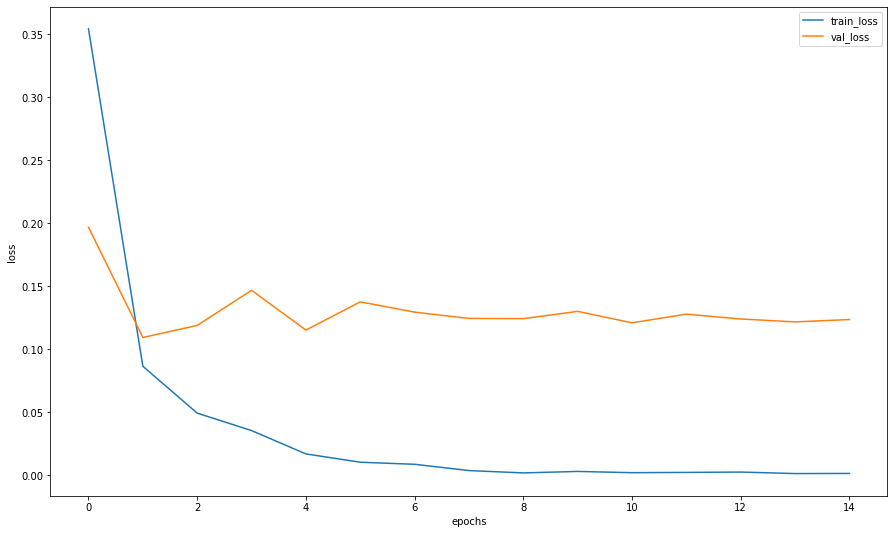

In [45]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Сохранение модели

https://stepik.org/lesson/345648/step/1?discussion=1634667&unit=609598

In [50]:
trained_model_name = "efficientnet-weights-for-springfield-classification.pth"
trained_model_weights = copy.deepcopy(model.state_dict())
torch.save(trained_model_weights, trained_model_name)

In [54]:
model.load_state_dict(torch.load(trained_model_name))

<All keys matched successfully>

### Применение модели

In [62]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [56]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [65]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(model, imgs)

In [67]:
y_pred = np.argmax(probs_imgs,-1)
actual_labels = [val_dataset[id][1] for id in idxs]

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [71]:
f1_score(actual_labels, y_pred, average='weighted')

0.9714285714285713

### Визуализация

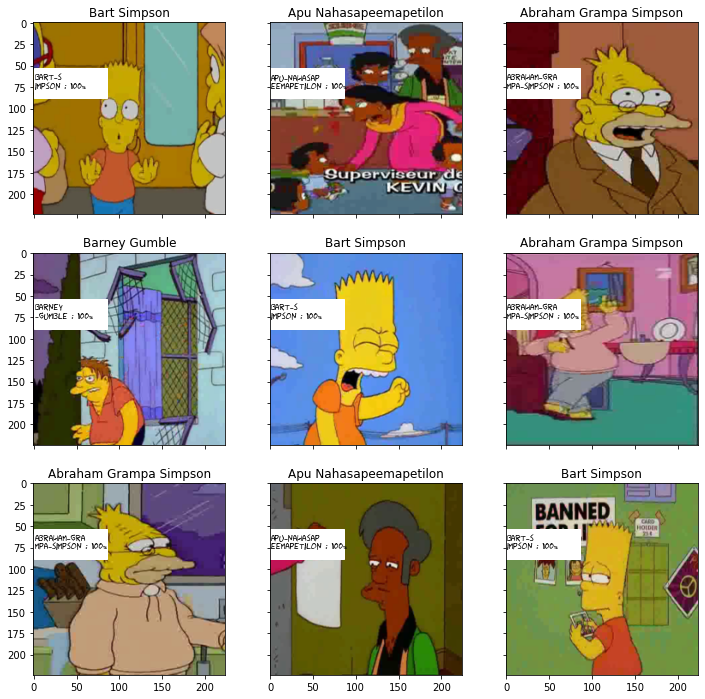

In [74]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Для Кагла

In [79]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [82]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [83]:
my_submit.to_csv('gdrive/MyDrive/my_springfield_submission.csv', index=False)